## SPX and NASDAQ Strategy

## [IBS](https://www.quantifiedstrategies.com/the-internal-bar-strength-ibs-indicator/)

IBS is simply an indicator where you buy on weakness and sell on strength, the cornerstone of any mean-reverting strategy. It oscillates from zero to one and measures the relative position of the closing price relative to the High and Low. A low internal bar strength value is supposed to be bullish, and a high value is bearish (for the short-term). The assumption is that the market is mean-reverting.

* **The formula for IBS is as follows** : $$\frac{(Close - Low)}{(High - Low)}$$


**The IBS more or less only works on single stocks and stock indices. Furthermore, it works best on indices that have a broad selection of different industries.**

However, it performs best under conditions where uncertainty makes the stock markets volatile.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import plotly.express as px
import gc,os,sys
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
gc.collect()

0

In [2]:
plt.rcParams['figure.figsize'] = (18, 6)

In [3]:
plt.style.use('Solarize_Light2')

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Functions for Daily Volatility, Sharpe, MaxDrawDown, Returns

In [5]:
def daily_vol(X):
    '''
    calculates daily volatility
    '''
    return pd.Series(X).pct_change().std()*(252**0.5)*100

def total_return(X):
    '''
    calculate total returns
    '''
    return 100 * (pd.Series(X).iloc[-1] / pd.Series(X).iloc[0]-1)

def max_drawdown(X):
    '''
    Calculates max drawdown
    '''
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak:
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return -mdd*100


def sharpe_ratio(X):
    '''
    Calculate sharpe ratio from an array of values
    '''
    sr = pd.Series(X).pct_change().mean()/pd.Series(X).pct_change().std()
    sr = (252**0.5)*sr
    return sr

def calculate_bt(X):
    return total_return(X), sharpe_ratio(X), max_drawdown(X), daily_vol(X)

In [31]:
def VWAP(close: pd.Series, volume: pd.Series)->pd.Series:
    '''
    Takes Close and Volume and calculates Volume weighted average price
    '''
    return (np.cumsum(volume * close) / np.cumsum(volume))

In [33]:
def zscore(xdf,rw=22):
    '''
    Takes Close and Calculates the zscore with given rolling window
    '''
    return (xdf - xdf.rolling(rw).mean()) / xdf.rolling(rw).std()

## [IBS](https://www.quantifiedstrategies.com/the-internal-bar-strength-ibs-indicator/)

IBS is simply an indicator where you buy on weakness and sell on strength, the cornerstone of any mean-reverting strategy. It oscillates from zero to one and measures the relative position of the closing price relative to the High and Low. A low internal bar strength value is supposed to be bullish, and a high value is bearish (for the short-term). The assumption is that the market is mean-reverting.

* **The formula for IBS is as follows** : $$\frac{(Close - Low)}{(High - Low)}$$


**The IBS more or less only works on single stocks and stock indices. Furthermore, it works best on indices that have a broad selection of different industries.**

However, it performs best under conditions where uncertainty makes the stock markets volatile.

In [11]:
tick = yf.Ticker("ES=F")

In [69]:
hist = tick.history(period="max")
hist = hist.reset_index()

In [70]:
hist['IBS'] = (hist['Close']-hist['Low'])/(hist['High']-hist['Low'])
## Calculating different moving average prices
hist['mv200'] = hist['Close'].rolling(200).mean()*1.05
hist['mv22'] = hist['Close'].rolling(22).mean()
hist['mv66'] = hist['Close'].rolling(66).mean()

In [71]:
def ibs_ret(Xdf:pd.DataFrame, 
            buy_sig:float=0.2, 
            sell_sig:float=0.8, 
            show:bool=True, 
            lbl_col:str='IBS')->list:
    '''
    parameters;
    Takes buy signal and sell signal and calculates returns based on IBS strategy
    Xdf : dataset with OHLC prices
    buy_sig : to buy at what threshold
    sell_sig : to sell at what threshold
    lbl_col : col that contains calculated IBS values
    
    Returns : IBS returns, buy_date, sell_date,list of lows between buy and sell ,IBS_entery_values, IBS_exit_values,
    '''
    en = buy_sig
    ex = sell_sig
    inmkt = False
    ret = []
    entry = 0
    tmp5 = Xdf.reset_index(drop=True)
    en_dt = []
    ex_dt = []
    low_lst = []
    buy_ibs = []
    sell_ibs = []
    for i in range(len(tmp5[lbl_col])):
        if tmp5.loc[i,lbl_col]<en and inmkt==False:# and  tmp5.loc[i,'Close']<tmp.loc[i,'mv200']*1.05:
            entry = tmp5.loc[i,'Close']
            inmkt = True
            en_dt.append(tmp5.loc[i,'Date'])
            buy_ibs.append(tmp5.loc[i,'IBS'])
            if show:
                print('entry_date',tmp5.loc[i,'Date'])
        if tmp5.loc[i,lbl_col]>ex and inmkt==True:
            exit = tmp5.loc[i,'Close']
            ret.append((exit-entry)/entry)
            inmkt=False
            ex_dt.append(tmp5.loc[i,'Date'])
            sell_ibs.append(tmp5.loc[i,'IBS'])
            if show:
                print('exit_date',tmp5.loc[i,'Date'])
            low_lst.append(tmp[tmp['Date'].between(en_dt[-1],tmp5.loc[i,'Date'])]['Low'].values)
    return np.array(ret),[en_dt,ex_dt,low_lst,buy_ibs,sell_ibs]

In [72]:
tmp = hist.iloc[:].reset_index(drop=True).copy()
tmp.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,IBS,mv200,mv22,mv66
5697,2023-04-04,4152.50,4171.75,4115.25,4129.00,1582414,0,0,0.243363,4148.214053,3997.400002,4016.246970
5698,2023-04-05,4134.00,4135.50,4099.00,4117.25,1470176,0,0,0.500000,4150.048928,4000.343184,4020.129546
5699,2023-04-06,4113.75,4135.25,4096.50,4132.00,73009,0,0,0.916129,4151.987490,4006.809093,4024.462880
5700,2023-04-10,4139.00,4143.00,4098.75,4136.25,73009,0,0,0.847458,4153.754115,4013.229548,4028.428789
5701,2023-04-11,4138.50,4149.00,4137.25,4139.50,113023,0,0,0.191489,4154.926178,4023.206820,4033.133334


In [68]:
ret,dts = ibs_ret(tmp.iloc[:],buy_sig=0.2,sell_sig=0.8,show=False,lbl_col='IBS')

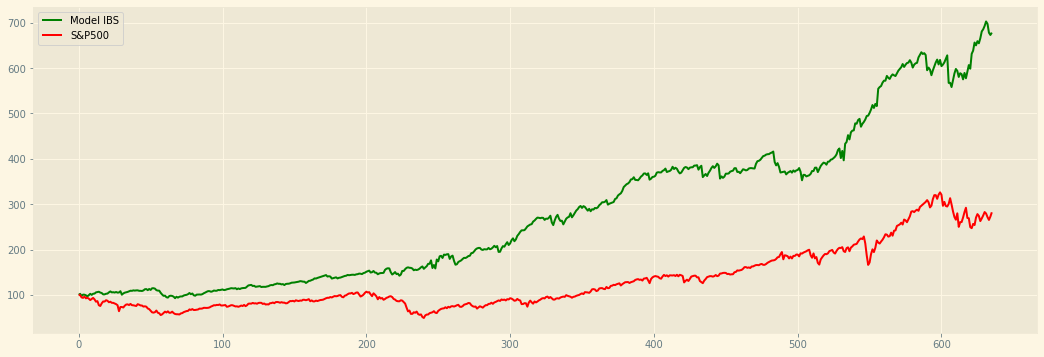

S&P500:
Returns 182.078
Sharpe 0.330
MaxDrawDown -57.113
Daily Vol 19.852
IBS Model :
Returns 577.815
Sharpe 2.593
MaxDrawDown -19.189
Daily Vol 31.219


In [75]:
y1 = 100*(1+pd.Series(ret)).cumprod().values
y2 = 100*(1+tmp['Close'].pct_change()[1:]).cumprod().values
idx = np.round(np.linspace(0, len(y2) - 1, len(y1))).astype(int)
plt.plot(y1,label='Model IBS',color='green')
plt.plot(y2[idx],label='S&P500',color='red')
plt.legend()
plt.show()
print("S&P500:\nReturns {0:.3f}\nSharpe {1:.3f}\nMaxDrawDown {2:.3f}\nDaily Vol {3:.3f}".format(*calculate_bt(tmp['Close'])))
print("IBS Model :\nReturns {0:.3f}\nSharpe {1:.3f}\nMaxDrawDown {2:.3f}\nDaily Vol {3:.3f}".format(*calculate_bt(100*(1+pd.Series(ret)).cumprod())))

In [47]:
ibs_ret_df = pd.DataFrame(np.column_stack((np.array(ret),
                 dts[0][:len(ret)],
                dts[1][:len(ret)],
                dts[3][:len(ret)],
                dts[4][:len(ret)])),
            columns=['Returns','buy_date','sell_date','IBS_at_buy_close','IBS_at_sell_close'])
ibs_ret_df['days in market'] = ibs_ret_df['sell_date']-ibs_ret_df['buy_date']
ibs_ret_df['Ret%'] = ibs_ret_df['Returns']*100

In [48]:
ibs_ret_df.tail(20)

,Returns,buy_date,sell_date,IBS_at_buy_close,IBS_at_sell_close,days in market,Ret%
616,0.024643,2022-09-30,2022-10-03,0.063452,0.846429,3 days,2.464251
617,-0.019964,2022-10-06,2022-10-13,0.097122,0.918263,7 days,-1.996406
618,0.025504,2022-10-14,2022-10-17,0.04386,0.881696,3 days,2.550382
619,0.024148,2022-10-20,2022-10-21,0.110092,0.929791,1 days,2.414802
620,-0.013127,2022-11-01,2022-11-07,0.178808,0.922156,6 days,-1.312726
621,0.05472,2022-11-09,2022-11-10,0.055696,0.943694,1 days,5.471974
622,0.011157,2022-11-14,2022-11-22,0.037383,0.966543,8 days,1.115734
623,0.027958,2022-11-28,2022-11-30,0.156863,0.91874,2 days,2.795794
624,-0.009367,2022-12-05,2022-12-08,0.180791,0.812245,3 days,-0.936739
625,0.0141,2022-12-09,2022-12-12,0.104167,0.985348,3 days,1.409971


## Year on Year Returns, Sharpe, Maxdrawdown, Accuray, Total Trades in year

In [49]:
ibs_ret_df['buy_year'] = ibs_ret_df['buy_date'].dt.year

In [50]:
ibs_gret = ibs_ret_df.groupby('buy_year').agg({'Returns':[('returns/yr',lambda x:total_return(100*(1+np.array(x)).cumprod())),
                                ('sharpe/yr',lambda x:sharpe_ratio(100*(1+np.array(x)).cumprod())),
                                ('MaxDrawDown/yr',lambda x:max_drawdown(100*(1+np.array(x)).cumprod())),
                                ('Accuracy/yr', lambda x:np.mean(x>0)),
                                ('Total Trades/yr','count')]})
ibs_gret.style.background_gradient(cmap='Greens',axis=0)

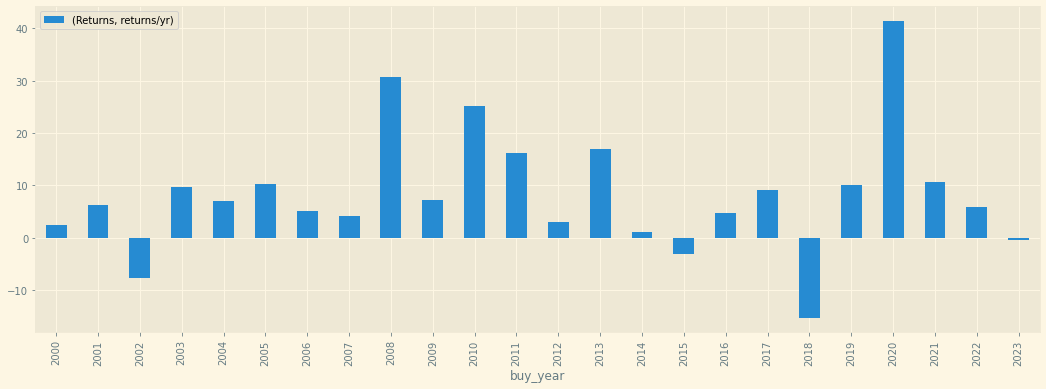

In [51]:
ibs_gret[('Returns','returns/yr')].plot(kind='bar')
plt.legend();

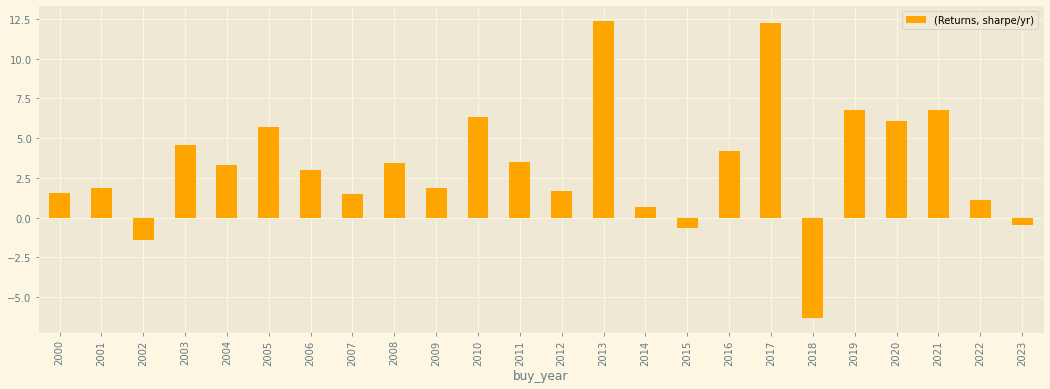

In [52]:
ibs_gret[('Returns','sharpe/yr')].plot(kind='bar',color='orange')
plt.legend();

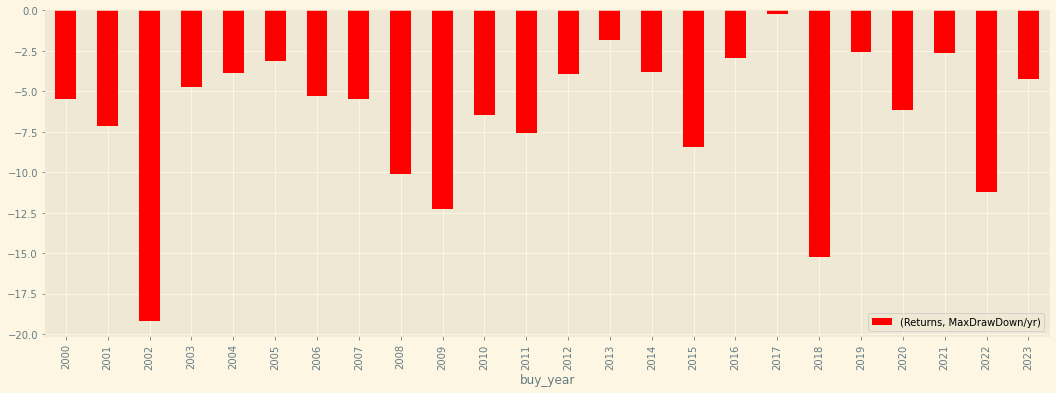

In [53]:
ibs_gret[('Returns','MaxDrawDown/yr')].plot(kind='bar',color='red')
plt.legend();